In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predicta-1-0-predict-the-unpredictable/submission_key.csv
/kaggle/input/predicta-1-0-predict-the-unpredictable/sample_submission.csv
/kaggle/input/predicta-1-0-predict-the-unpredictable/historical_weather.csv


In [28]:
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math

In [2]:
data = pd.read_csv('/kaggle/input/predicta-1-0-predict-the-unpredictable/historical_weather.csv')
data.head()

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh
0,C001,2014-01-01,6.6,-1.4,11.6,NaN,NaN,168.0,6.2
1,C001,2014-01-02,9.3,6.3,13.3,NaN,NaN,155.0,10.0
2,C001,2014-01-03,7.6,1.9,14.0,NaN,NaN,NaN,5.8
3,C001,2014-01-04,7.6,3.9,13.3,NaN,NaN,291.0,11.3
4,C001,2014-01-05,8.6,0.5,16.9,NaN,NaN,NaN,5.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182338 entries, 0 to 182337
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city_id             182338 non-null  object 
 1   date                182338 non-null  object 
 2   avg_temp_c          181114 non-null  float64
 3   min_temp_c          176452 non-null  float64
 4   max_temp_c          174845 non-null  float64
 5   precipitation_mm    112594 non-null  float64
 6   snow_depth_mm       12238 non-null   float64
 7   avg_wind_dir_deg    146944 non-null  float64
 8   avg_wind_speed_kmh  159866 non-null  float64
dtypes: float64(7), object(2)
memory usage: 12.5+ MB


In [4]:
data['date'] = pd.to_datetime(data['date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182338 entries, 0 to 182337
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   city_id             182338 non-null  object        
 1   date                182338 non-null  datetime64[ns]
 2   avg_temp_c          181114 non-null  float64       
 3   min_temp_c          176452 non-null  float64       
 4   max_temp_c          174845 non-null  float64       
 5   precipitation_mm    112594 non-null  float64       
 6   snow_depth_mm       12238 non-null   float64       
 7   avg_wind_dir_deg    146944 non-null  float64       
 8   avg_wind_speed_kmh  159866 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 12.5+ MB


In [5]:
data.shape

(182338, 9)

In [6]:
data['city_id'].unique()

array(['C001', 'C002', 'C003', 'C004', 'C005', 'C007', 'C008', 'C009',
       'C010', 'C011', 'C012', 'C013', 'C014', 'C015', 'C016', 'C017',
       'C018', 'C020', 'C022', 'C023', 'C024', 'C025', 'C027', 'C028',
       'C029', 'C030', 'C031', 'C033', 'C034', 'C035', 'C036', 'C037',
       'C038', 'C039', 'C040', 'C042', 'C043', 'C044', 'C045', 'C046',
       'C047', 'C048', 'C049', 'C051', 'C053', 'C054', 'C055', 'C056',
       'C057', 'C058', 'C059', 'C061', 'C062', 'C064', 'C065', 'C066',
       'C067', 'C068', 'C069', 'C070', 'C071', 'C072', 'C073', 'C074',
       'C076', 'C077', 'C078', 'C079', 'C081', 'C082', 'C083', 'C084',
       'C085', 'C086', 'C087', 'C088', 'C089', 'C090', 'C091', 'C092',
       'C093', 'C094', 'C095', 'C096', 'C097', 'C098', 'C099', 'C100',
       'C101', 'C102', 'C103', 'C104', 'C105', 'C106', 'C107', 'C108',
       'C109', 'C110', 'C111', 'C112'], dtype=object)

In [7]:
data['city_id'].nunique()

100

In [8]:
t = [c for c in data['city_id'].value_counts() < data['city_id'].value_counts().max()].count(True)
t, 100-t

(38, 62)

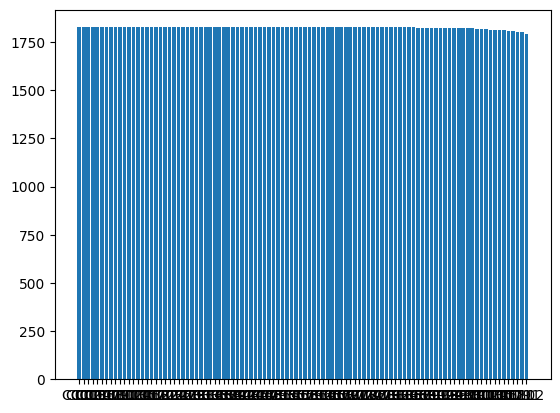

In [10]:
plt.bar(data['city_id'].unique(), [val for val in data['city_id'].value_counts().values])
plt.show()

In [11]:
groups = data.groupby('city_id')
city_groups = [groups.get_group(city) for city in groups.groups]
city_groups[0]

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh
0,C001,2014-01-01,6.6,-1.4,11.6,NaN,NaN,168.0,6.2
1,C001,2014-01-02,9.3,6.3,13.3,NaN,NaN,155.0,10.0
2,C001,2014-01-03,7.6,1.9,14.0,NaN,NaN,NaN,5.8
3,C001,2014-01-04,7.6,3.9,13.3,NaN,NaN,291.0,11.3
4,C001,2014-01-05,8.6,0.5,16.9,NaN,NaN,NaN,5.0
...,...,...,...,...,...,...,...,...,...
1821,C001,2018-12-27,9.7,4.0,17.0,0.0,NaN,157.0,6.2
1822,C001,2018-12-28,10.1,5.7,17.0,0.0,NaN,188.0,5.2
1823,C001,2018-12-29,8.9,4.0,17.0,0.0,NaN,164.0,6.2
1824,C001,2018-12-30,10.7,5.0,18.0,0.0,NaN,160.0,8.1


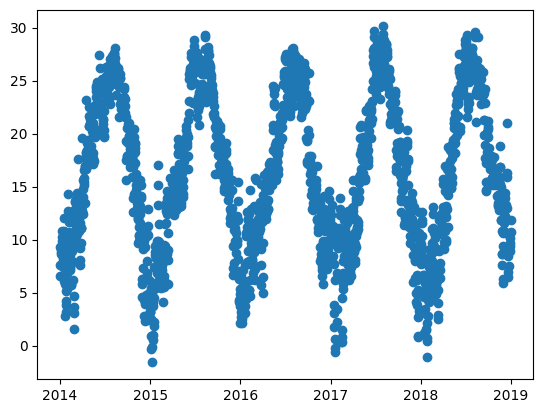

In [12]:
plt.scatter(city_groups[0]['date'], city_groups[0]['avg_temp_c'])
plt.show()

# Data Preprocessing

In [13]:
for city in city_groups:
    city.drop(city.columns[3:], axis=1, inplace=True)

city_groups[0].head()

/tmp/ipykernel_86/480226888.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city.drop(city.columns[3:], axis=1, inplace=True)


,city_id,date,avg_temp_c
0,C001,2014-01-01,6.6
1,C001,2014-01-02,9.3
2,C001,2014-01-03,7.6
3,C001,2014-01-04,7.6
4,C001,2014-01-05,8.6


In [14]:
for city in city_groups:
    city['year'] = city['date'].dt.year
    city['month'] = city['date'].dt.month
    city['day'] = city['date'].dt.day
    city.drop('date', axis=1, inplace=True)

city_groups[0].head()

/tmp/ipykernel_86/1571792109.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city['year'] = city['date'].dt.year
/tmp/ipykernel_86/1571792109.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city['month'] = city['date'].dt.month
/tmp/ipykernel_86/1571792109.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

,city_id,avg_temp_c,year,month,day
0,C001,6.6,2014,1,1
1,C001,9.3,2014,1,2
2,C001,7.6,2014,1,3
3,C001,7.6,2014,1,4
4,C001,8.6,2014,1,5


In [15]:
for city in city_groups:
    city['city_id'] = city['city_id'].str.replace('C', '')
    city['city_id'] = city['city_id'].apply(pd.to_numeric)

city_groups[0].info()

/tmp/ipykernel_86/3927434803.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city['city_id'] = city['city_id'].str.replace('C', '')
/tmp/ipykernel_86/3927434803.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city['city_id'] = city['city_id'].apply(pd.to_numeric)


<class 'pandas.core.frame.DataFrame'>
Index: 1826 entries, 0 to 1825
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   city_id     1826 non-null   int64  
 1   avg_temp_c  1826 non-null   float64
 2   year        1826 non-null   int32  
 3   month       1826 non-null   int32  
 4   day         1826 non-null   int32  
dtypes: float64(1), int32(3), int64(1)
memory usage: 64.2 KB


**Handling Missing Values**

In [16]:
# Check for missing values
data.isnull().sum()

city_id                    0
date                       0
avg_temp_c              1224
min_temp_c              5886
max_temp_c              7493
precipitation_mm       69744
snow_depth_mm         170100
avg_wind_dir_deg       35394
avg_wind_speed_kmh     22472
dtype: int64

In [17]:
# Drop columns with null values more tha 80%
[col for col in data.isnull().sum().keys() if data.isnull().sum()[col]/data.shape[0] > 0.8]

['snow_depth_mm']

In [19]:
# Filling null values with KNN
imputer = KNNImputer(n_neighbors=2)
imputeds = [imputer.fit_transform(city.iloc[:, 1:2]) for city in city_groups]

for index, city in enumerate(city_groups):
    city.iloc[:, 1:2] = imputeds[index]

city_groups[0].head()

,city_id,avg_temp_c,year,month,day
0,1,6.6,2014,1,1
1,1,9.3,2014,1,2
2,1,7.6,2014,1,3
3,1,7.6,2014,1,4
4,1,8.6,2014,1,5


In [20]:
city_groups[0].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1826 entries, 0 to 1825
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   city_id     1826 non-null   int64  
 1   avg_temp_c  1826 non-null   float64
 2   year        1826 non-null   int32  
 3   month       1826 non-null   int32  
 4   day         1826 non-null   int32  
dtypes: float64(1), int32(3), int64(1)
memory usage: 64.2 KB


In [21]:
city_groups[0].isnull().sum()

city_id       0
avg_temp_c    0
year          0
month         0
day           0
dtype: int64

# Models Training and Predicting

In [22]:
# Selecte dependent and independent features
x = city_groups[0].drop('avg_temp_c', axis=1)
y = city_groups[0]['avg_temp_c']

In [24]:
# Split dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [26]:
# Train model
pf = PolynomialFeatures(degree=5)
x_poly = pf.fit_transform(x_train)

test_model = LinearRegression()
test_model.fit(x_poly, y_train)

LinearRegression()

In [27]:
# Check the accuracy score
x_test_poly = pf.transform(x_test)
test_model.score(x_test_poly, y_test) * 100

86.28958296072311

In [29]:
# Find RMSE
test_pred = test_model.predict(x_test_poly)
test_mse = mean_squared_error(y_test, test_pred)
test_rmse = math.sqrt(test_mse)
test_rmse

2.680585251654469

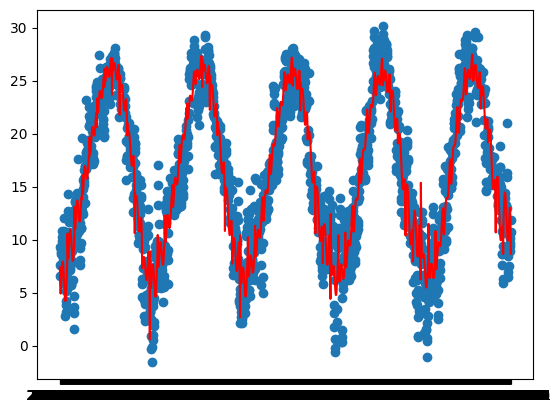

In [30]:
x_poly = pf.transform(x)
all_preds = test_model.predict(x_poly)
x_dates = x[x.columns[1:]].apply(lambda m: '-'.join(m.dropna().astype(str)), axis=1)

plt.scatter(x_dates, y)
plt.plot(x_dates, all_preds, c='red')
plt.show()

# Automate the Train and Predict processes for all cities

In [31]:
accuracies = []
rmses = []
i = 0

df = pd.read_csv('/kaggle/input/predicta-1-0-predict-the-unpredictable/sample_submission.csv')

for city in city_groups:
    # Split dependent and independent data
    X = city.drop('avg_temp_c', axis=1)
    Y = city['avg_temp_c']
    
    # Split train and testing data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
    
    # Train model
    PF = PolynomialFeatures(degree=5)
    X_poly = PF.fit_transform(X_train)
    
    model = LinearRegression()
    model.fit(X_poly, Y_train)
    
    # Get accuracy score
    X_test_poly = PF.transform(X_test)
    accuracy = model.score(X_test_poly, Y_test) * 100
    accuracies.append(accuracy)
    
    # Get RMSE
    pred = model.predict(X_test_poly)
    mse = mean_squared_error(Y_test, pred)
    rmse = math.sqrt(mse)
    rmses.append(rmse)
    
    # Get predictions
    city_id = city['city_id'].unique()[0]
    cities = [city_id for l in range(7)]
    years = [2019 for l in range(7)]
    months = [1 for l in range(7)]
    days = [l for l in range(1, 8)]
    
    given_data = pd.DataFrame({'city_id': cities, 'year': years, 'month': months, 'day': days})
    given_data_poly = PF.transform(given_data)
    predictions = model.predict(given_data_poly)
    
    # Include predictions into the dataframe
    for prediction in predictions:
        df.loc[i, 'avg_temp_c'] = prediction
        i += 1
    
    # Print details
    print(f"---------- {i/7}/100 Done        Accuracy: {accuracy}        RMSE: {rmse} ----------")

---------- 1.0/100 Done        Accuracy: 80.36530150391182        RMSE: 3.1876850167076283 ----------
---------- 2.0/100 Done        Accuracy: 84.73818431013112        RMSE: 1.89965746212373 ----------
---------- 3.0/100 Done        Accuracy: 86.98157489374283        RMSE: 0.7864260692594307 ----------
---------- 4.0/100 Done        Accuracy: 77.13921541536259        RMSE: 3.799852183942451 ----------
---------- 5.0/100 Done        Accuracy: 78.91188432153027        RMSE: 2.4246530937563775 ----------
---------- 6.0/100 Done        Accuracy: 77.10373143719914        RMSE: 2.9904747202250404 ----------
---------- 7.0/100 Done        Accuracy: 82.31650419732144        RMSE: 3.3573715222867455 ----------
---------- 8.0/100 Done        Accuracy: 93.33305557207535        RMSE: 1.7075399912520783 ----------
---------- 9.0/100 Done        Accuracy: 72.55903724909052        RMSE: 2.148511300798788 ----------
---------- 10.0/100 Done        Accuracy: 79.6256888935109        RMSE: 4.157040836573

In [32]:
np.mean(accuracies), np.min(accuracies), np.max(accuracies)

(68.59139254442051, 4.401044951421163, 94.31564960789788)

In [33]:
np.mean(rmses), np.min(rmses), np.max(rmses)

(2.3840436429651675, 0.7154850620214904, 5.970785554192252)

In [36]:
# Write predictions to the output file
df.to_csv('/kaggle/working/sample_submission.csv', index=False)